https://github.com/alan-turing-institute/sktime/blob/v0.4.3/examples/01_forecasting.ipynb

In [2]:
import sktime
# Install tsfresh as well
import pandas as pd
import numpy as np
from warnings import simplefilter

from sktime.forecasting.all import *
from warnings import simplefilter

simplefilter("ignore", FutureWarning)
%matplotlib inline


/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
fname = "../data/Rajasthan/2000.csv"
df = pd.read_csv(fname)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.groupby(["Year", "Month", "Day"]).mean()
y = df['Wind Speed']
y.index = pd.date_range('2000-01-01', periods=len(df), freq='D')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Wind Speed'>)

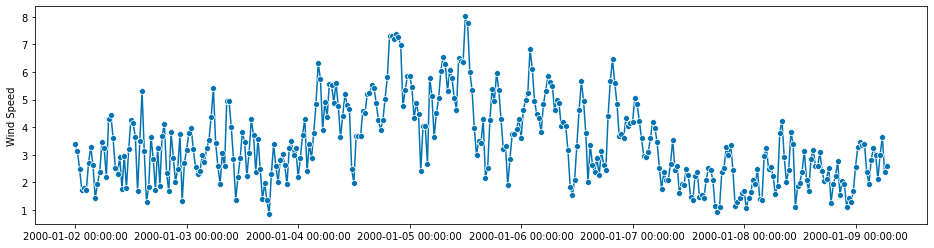

In [4]:
plot_series(y)

255 110


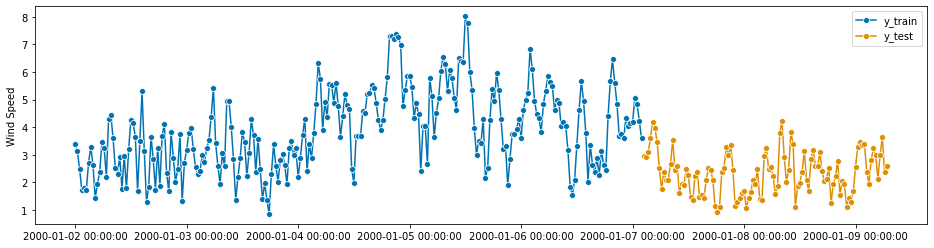

In [6]:
y_train, y_test = temporal_train_test_split(y, test_size=0.3)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);
print(y_train.shape[0], y_test.shape[0])

In [7]:
fh = np.arange(len(y_test)) + 1
fh

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110])

In [8]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2000-09-12', '2000-09-13', '2000-09-14', '2000-09-15',
               '2000-09-16', '2000-09-17', '2000-09-18', '2000-09-19',
               '2000-09-20', '2000-09-21',
               ...
               '2000-12-21', '2000-12-22', '2000-12-23', '2000-12-24',
               '2000-12-25', '2000-12-26', '2000-12-27', '2000-12-28',
               '2000-12-29', '2000-12-30'],
              dtype='datetime64[ns]', length=110, freq='D', is_relative=False)

0.4718644508661673

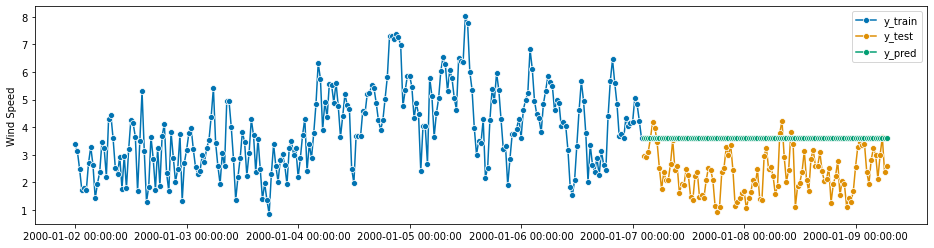

In [9]:
# using sktime
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

0.5550432825191962

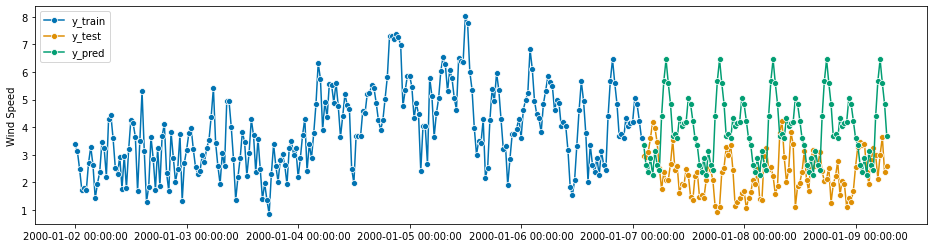

In [11]:
forecaster = NaiveForecaster(strategy="last", sp=24)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plt = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

0.5672265119320767

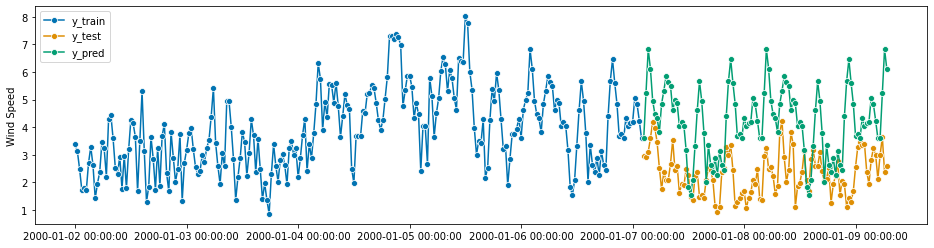

In [21]:

from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=24, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)


0.5553830034120518

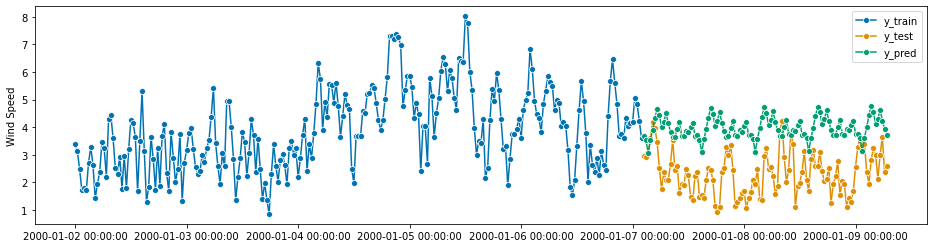

In [22]:
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=24)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=24)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=24))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [23]:
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = ReducedRegressionForecaster(regressor, window_length=24, strategy="recursive")

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

NameError: name 'RandomForestRegressor' is not defined